In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from pyne import nucname

In [2]:
! git clone https://github.com/jbae11/ann_pwr
! cd ann_pwr
! python setup.py install
! cyclus ./input/increasing_bu.xml -o increasing_bu.sqlite
! cyclus ./input/increasing_cycletime.xml -o increasing_cycletime.sqlite

Cloning into 'ann_pwr'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 350 (delta 186), reused 347 (delta 183), pack-reused 0
Receiving objects: 100% (350/350), 580.80 KiB | 0 bytes/s, done.
Resolving deltas: 100% (186/186), done.
Checking connectivity... done.
python: can't open file 'setup.py': [Errno 2] No such file or directory
              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CC

In [6]:
con = lite.connect('/home/4ib/git/ann_pwr/input/increasing_bu.sqlite')
con.row_factory = lite.Row
cur = con.cursor()

In [7]:
# unf composition
nucid_list = []
isos = cur.execute('SELECT distinct(nucid) FROM compositions').fetchall()
for i in isos:
    nucid_list.append(i['nucid'])
print(nucid_list)

[922350000, 922380000, 10010000, 10030000, 60140000, 340790000, 360850000, 380900000, 390900000, 400930000, 400950000, 410940000, 410950000, 430990000, 441030000, 441060000, 461070000, 471080001, 471100001, 501260000, 511240000, 511250000, 531290000, 551340000, 551350000, 551370000, 581440000, 611470000, 621510000, 631520000, 631540000, 631550000, 882260000, 892270000, 902290000, 902300000, 902320000, 912310000, 922320000, 922330000, 922340000, 922360000, 932370000, 942380000, 942390000, 942400000, 942410000, 942420000, 942440000, 952410000, 952420001, 952430000, 962420000, 962430000, 962440000, 962450000, 962460000, 962470000, 962480000, 982490000, 982510000]


In [40]:
def get_isotopic_plot(isotope_list, xlabel, ylabel, title, filename, ylim=[0, 1], normalize=False):    
    iso_trans_dict = {}
    for iso in isotope_list:
        mass_frac_list = []
        unf = cur.execute('SELECT time, massfrac FROM transactions '
                          'INNER JOIN resources ON '
                          'resources.resourceid = transactions.resourceid '
                          'INNER join compositions ON '
                          'compositions.qualid = resources.qualid '
                          'WHERE nucid = %s and commodity= "unf"' %str(iso)).fetchall()
        for row in unf:
            mass_frac_list.append(row['massfrac'] * 100)
        iso_trans_dict[iso] = mass_frac_list
        
    
    if normalize:
        for i in range(len(mass_frac_list)):
            tot = 0
            for j in iso_trans_dict.keys():
                tot += iso_trans_dict[j][i]
            for j in iso_trans_dict.keys():
                iso_trans_dict[j][i] = iso_trans_dict[j][i] / tot
    for key, val in iso_trans_dict.items():
        plt.scatter(range(len(val)), val, label=nucname.name(key))
    axes = plt.gca()
    axes.set_ylim(ylim)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.title(title)
    plt.savefig(filename, format='png', bbox_inches='tight')
    plt.show()

## Plutonium vector inventory

In [41]:
# unf composition
nucid_list = []
isos = cur.execute('SELECT distinct(nucid) FROM compositions').fetchall()
for i in isos:
    if i['nucid']//10000000 == 94:
        nucid_list.append(i['nucid'])
print(nucid_list)

[942380000, 942390000, 942400000, 942410000, 942420000, 942440000]


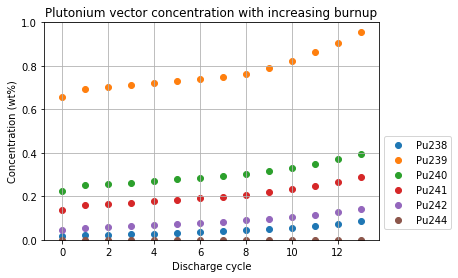

In [44]:
get_isotopic_plot(nucid_list, 'Discharge cycle', 'Concentration (wt%)',
                  'Plutonium vector concentration with increasing burnup',
                  './images/cyclus_imp/pu.png', normalize=False)

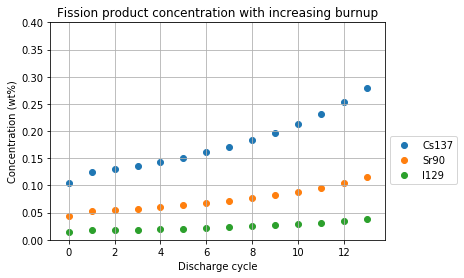

In [43]:
get_isotopic_plot([551370000, 380900000, 531290000], 'Discharge cycle', 'Concentration (wt%)',
                  'Fission product concentration with increasing burnup', './images/cyclus_imp/fp.png', ylim=[0,0.4])

In [12]:
# input fuel enrichment
# unf composition
iso_trans_dict = {}
for iso in [922350000, 922380000]:
    mass_frac_list = []
    unf = cur.execute('SELECT time, massfrac FROM transactions '
                      'INNER JOIN resources ON '
                      'resources.resourceid = transactions.resourceid '
                      'INNER join compositions ON '
                      'compositions.qualid = resources.qualid '
                      'WHERE nucid = %s and commodity= "fuel"' %str(iso)).fetchall()
    for row in unf:
        mass_frac_list.append(row['massfrac'])
    iso_trans_dict[iso] = mass_frac_list

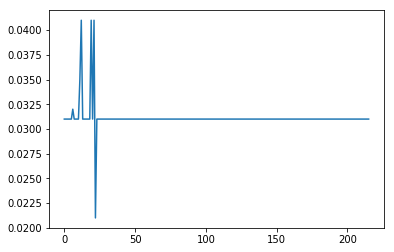

In [13]:
plt.plot(iso_trans_dict[922350000])

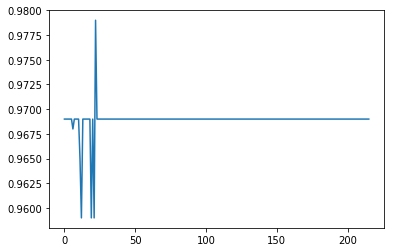

In [14]:
plt.plot(iso_trans_dict[922380000])

## Increasing cycle time

In [17]:
con = lite.connect('/home/4ib/git/ann_pwr/input/increasing_cycletime.sqlite')
con.row_factory = lite.Row
cur = con.cursor()

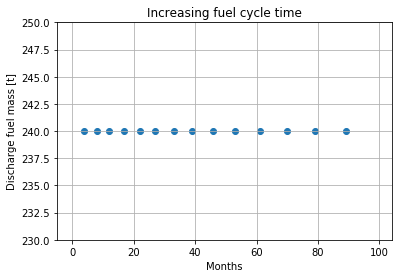

In [46]:
rows = cur.execute('SELECT time, quantity, Qualid FROM transactions '
                   'INNER JOIN resources ON resources.resourceid =transactions.resourceid '
                   'WHERE commodity="unf"').fetchall()
time = []
out = []
cm = []

for row in rows:
    q = row['Qualid']
    z = cur.execute('SELECT MassFrac FROM compositions WHERE qualid==%s and nucid==962440000' %str(q)).fetchone()
    cm.append(z[0])
    time.append(row['time'])

timeseries = []
for i in range(100):
    timeseries.append(i)
    if i in time:
        out.append(row['quantity'] / 1e3)
    else:
        out.append(0)

plt.scatter(timeseries, out)
axes = plt.gca()
axes.set_ylim([2.3e2, 2.5e2])
plt.xlabel('Months')
plt.ylabel('Discharge fuel mass [t]')
plt.title('Increasing fuel cycle time')
plt.grid()
plt.savefig('./images/cyclus_imp/cycle_time.png', format='png')
plt.show()

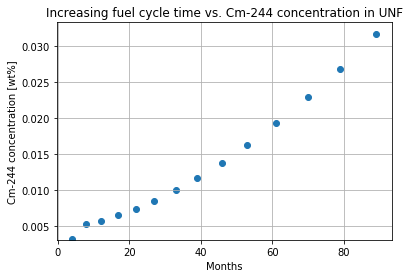

In [64]:
new_cm = [q * 1e2 for q in cm]
plt.close()
plt.scatter(time, new_cm)
axes = plt.gca()
plt.xlabel('Months')
axes.set_ylim([min(new_cm) - min(new_cm)*0.05, max(new_cm) + max(new_cm) * 0.05])
plt.ylabel('Cm-244 concentration [wt%]')
plt.title('Increasing fuel cycle time vs. Cm-244 concentration in UNF')
plt.grid()
plt.savefig('./images/cyclus_imp/cycle_time.png', format='png')
plt.show()

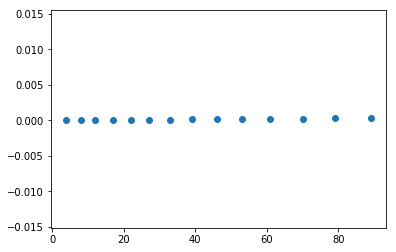